<a href="https://colab.research.google.com/github/Jihyun13579/ESAA/blob/main/1013(%EA%B8%88)_%EA%B3%BC%EC%A0%9C_%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_%EC%99%84%EB%B2%BD_%EA%B0%80%EC%9D%B4%EB%93%9C_ch8_5_p_497_~_512_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1013(금) 과제_파이썬 머신러닝 완벽 가이드 ch8. 5  p. 497 ~ 512 필사

### 2129014 박지현

# CH08. 텍스트 분석

## CH08.05. 감성 분석

### 감성 분석 소개
감성 분석(Sentiment Analysis): 문서의 주관적인 감성/의견/감정/시분 등을 파악하기 위한 방법
- 소셜 미디어, 여론조사, 온라인 리뷰, 피드백 등 다양한 분야에서 활용됨
- 문서 내 텍스트가 나나태는 여러 가지 주관적인 단어와 문맥을 기반으로 감성(Sentiment) 수치를 계산하는 방법 이용
 - 감정 지수 : 긍정 감성 지수 / 부정 감성 지수 > 지수 합산 후 긍정/부정 감성 결정
- 지도 학습 VS 비지도학습
 - 지도학습 : 학습 데이터-타깃 레이블 값 기반 감성 분석 학습 수행 > 다른 데이터의 감성 분석 예측
 - 비지도학습: 일종의 감성 어휘 사전 'Lexicon'-감성 분석을 위한 용어와 문맥에 대한 다양한 정보를 가지고 있음 이용 > 문서의 긍정적, 부정적 감성 여부 판단

### 지도학습 기반 감성 분석 실습 - IMDB 영화평
- IMDB의 영화 시이트 영화평의 텍스트 분석해 감성 분석 결과가 긍정 또는 부정인지를 예측하는 모델 생성하기

1. 내려받은 데이터 불러오기
 - 데이터 파일: 탭 문자로 분리되어있음

In [8]:
import pandas as pd

review_df = pd.read_csv('/content/labeledTrainData.tsv', header=0, sep="\t", quoting=3)
review_df.head(3)

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."


- 데이터의 피처
 - id: 각 데이터의 id
 - sentiment: 영화평(review)의 Sentiment 결과 값(Target Label), 1: 긍정적 평가/0: 부정적 평가
 - review: 영화평의 텍스트

2. 텍스트가 어떻게 구성되어 있는지 review 칼럼의 텍스트 값을 하나만 살펴보기

In [9]:
print(review_df['review'][0])

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

3. 'review' 칼럼에서 의미 있는 문자열들만을 남겨두기

In [10]:
import re

# <br> html 태그는 replace 함수로 공백으로 변환
review_df['review'] = review_df['review'].str.replace('<br />', ' ')

# 파이썬의 정규 표현식 모듈인 re를 이용해 영어 문자열이 아닌 문자는 모두 공백으로 변환
review_df['review'] = review_df['review'].apply(lambda x : re.sub("[^a-zA-Z]", " ", x))

4. 결정 값 클래스인 sentiment 칼럼 별도로 추출해 결정 값 데이터 세트 만들고, 원본 데이터 세트에서 id와 sentiment 칼럼 삭제해 피처 데이터 세트 생성하기 > train_test_split() 이용해 학습용과 테스트용 데이터 세트로 분리하기

In [11]:
from sklearn.model_selection import train_test_split

class_df = review_df['sentiment']
feature_df = review_df.drop(['id', 'sentiment'], axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(feature_df, class_df, test_size=0.3, random_state=156)
X_train.shape, X_test.shape

((17500, 1), (7500, 1))

> 학습용 데이터 : 17500개의 리뷰 / 테스트용 데이터: 7500개의 리뷰로 구성됨

5. 감상평(Review) 텍스트를 피처 벡터화한 후에 ML 분류 알고리즘 적용해 예측 성능 측정하기
- Pipeline 객체 이용해 Count 벡터와를 적용해 예측 성능 측정하기 후 TF-IDF 벡터화 적용하기 2가지 한꺼번에 수행하기
- Classifier : LogisticRegression
- 예측 성능 평가 : 이진 분류 > 테트스 데이터 세트의 정확도 + ROC-AUC 모두 측정

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# 스톱 워드는 English, filtering, ngram은 (1,2)로 설정해 CountVectorization 수행.
# LogisticRegression의 C는 10으로 설정.
pipeline = Pipeline([
    ('cnt_vect', CountVectorizer(stop_words='english', ngram_range=(1,2) )),
    ('lr_clf', LogisticRegression(C=10))
])

# Pipeline 객체를 이용해 fit(), predict()로 학습/예측 수행. predict_proba()는 roc_auc 때문에 수행.
pipeline.fit(X_train['review'], y_train)
pred = pipeline.predict(X_test['review'])
pred_probs = pipeline.predict_proba(X_test['review'])[:,1]

print('예측 정확도는 {0:.4f}, ROC-AUC는 {1:.4f}'.format(accuracy_score(y_test, pred),
                                                 roc_auc_score(y_test, pred_probs)))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


예측 정확도는 0.8860, ROC-AUC는 0.9503


6. TF-IDF 벡터화를 적용해 다시 예측 성능 측정해보기

In [13]:
# 스톱 워드는 English, filtering, ngram은 (1,2)로 설정해 TF-IDF 벡터화 수행.
# LogisticRegression의 C는 10으로 설정.
pipeline = Pipeline([
    ('tfidf_vect', TfidfVectorizer(stop_words='english', ngram_range=(1,2) )),
    ('lr_clf', LogisticRegression(C=10))
])

pipeline.fit(X_train['review'], y_train)
pred = pipeline.predict(X_test['review'])
pred_probs = pipeline.predict_proba(X_test['review'])[:,1]

print('예측 정확도는 {0:.4f}, ROC-AUC는 {1:.4f}'.format(accuracy_score(y_test, pred),
                                                 roc_auc_score(y_test, pred_probs)))

예측 정확도는 0.8936, ROC-AUC는 0.9598


> TF_IDF 기반 피처 벡터화의 예측 성능이 조금 더 나아짐

### 비지도학습 기반 감성 분석 소개
- 비지도 감성 분석 : Lexicon 기반으로 하는 것, 대부분의 레이블 값 가지고 있지 않은 데이터에 유용하게 사용 가능
- NLP 패키지의 WordNet : '시맨틱 분석' 제공하는 어휘 사전 : '시맨틱(semantic)' = '문맥상의 의미', 동일한 단어나 문장이라도 다른 환경과 문맥에서는 다르게 표현되거나 이해될 수 있음 > WordNet : 다양한 상황에서 같은 어휘라도 다르게 사용되는 어휘의 시맨틱 정보 제공, 각각의 품사로 구성된 개별 단어를 Synset(Sets of cognitive synonyms, 그 단어가 가지는 문맥, 시맨틱 정보를 제공하는 WordNet의 핵심 개념)라는 개념 이용해 표현


- Lexicon : 주로 감성만을 분석하기 위해 지원하는 감성 어휘 사전, 감성 사전
 - 감성 지수(Polarity score): 긍정(Positive) 감성 또는 부정(Negative) 감성의 정도를 의미하는 수치를 가지고 있음
  - 단어의 위치, 주변 단어, 문맥, POS(Part of Speech) 등을 참고해 결정됨
  - 대표격 : NLTK 패키지 - 서브 모듈 감성 사전 Lexicon
  - 대표적인 감성 사전
  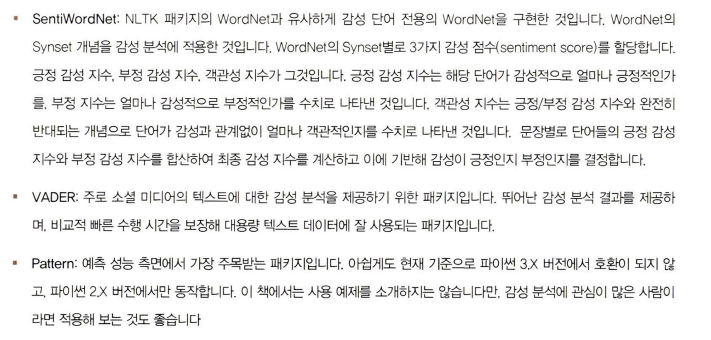


### SentiWordNet을 이용한 감성 분석

#### WordNet Synset과 SentiWordNet SentiSynset 클래스의 이해

In [14]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

True

In [15]:
from nltk.corpus import wordnet as wn

term = 'present'

# 'present'라는 단어로 wordnet의 synsets 생성.
synsets = wn.synsets(term)
print('synsets() 반환 type :', type(synsets))
print('synsets() 반환 값 갯수:', len(synsets))
print('synsets() 반환 값 :', synsets)

synsets() 반환 type : <class 'list'>
synsets() 반환 값 갯수: 18
synsets() 반환 값 : [Synset('present.n.01'), Synset('present.n.02'), Synset('present.n.03'), Synset('show.v.01'), Synset('present.v.02'), Synset('stage.v.01'), Synset('present.v.04'), Synset('present.v.05'), Synset('award.v.01'), Synset('give.v.08'), Synset('deliver.v.01'), Synset('introduce.v.01'), Synset('portray.v.04'), Synset('confront.v.03'), Synset('present.v.12'), Synset('salute.v.06'), Synset('present.a.01'), Synset('present.a.02')]


In [16]:
for synset in synsets :
    print('##### Synset name : ', synset.name(),'#####')
    print('POS :',synset.lexname())
    print('Definition:',synset.definition())
    print('Lemmas:',synset.lemma_names())
    print()

##### Synset name :  present.n.01 #####
POS : noun.time
Definition: the period of time that is happening now; any continuous stretch of time including the moment of speech
Lemmas: ['present', 'nowadays']

##### Synset name :  present.n.02 #####
POS : noun.possession
Definition: something presented as a gift
Lemmas: ['present']

##### Synset name :  present.n.03 #####
POS : noun.communication
Definition: a verb tense that expresses actions or states at the time of speaking
Lemmas: ['present', 'present_tense']

##### Synset name :  show.v.01 #####
POS : verb.perception
Definition: give an exhibition of to an interested audience
Lemmas: ['show', 'demo', 'exhibit', 'present', 'demonstrate']

##### Synset name :  present.v.02 #####
POS : verb.communication
Definition: bring forward and present to the mind
Lemmas: ['present', 'represent', 'lay_out']

##### Synset name :  stage.v.01 #####
POS : verb.creation
Definition: perform (a play), especially on a stage
Lemmas: ['stage', 'present', 'rep

- WordNet을 통해 어떤 어휘와 다른 어휘 간의 관계를 유사도로 나타내보기
 - 'tree' ,'lion', 'tiger', 'cat', 'dog'라는 단어의 상호 유사도 살펴보기

In [17]:
# synset 객체를 단어별로 생성

tree = wn.synset('tree.n.01')
lion = wn.synset('lion.n.01')
tiger = wn.synset('tiger.n.02')
cat = wn.synset('cat.n.01')
dog = wn.synset('dog.n.01')

entities = [tree , lion , tiger , cat , dog]
similarities = [] # 단어 유사도
entity_names = [entity.name().split('.')[0] for entity in entities]

# 단어별 synset들을 iteration 하면서 다른 단어들의 synset과 유사도를 측정
for entity in entities:
    similarity = [round(entity.path_similarity(compared_entity), 2)  for compared_entity in entities]
    similarities.append(similarity)

# 개별 단어별 synset과 다른 단어의 synset과의 유사도를 DataFrame형태로 저장
similarity_df = pd.DataFrame(similarities , columns = entity_names, index = entity_names)
similarity_df

,tree,lion,tiger,cat,dog
tree,1.00,0.07,0.07,0.08,0.12
lion,0.07,1.00,0.33,0.25,0.17
tiger,0.07,0.33,1.00,0.25,0.17
cat,0.08,0.25,0.25,1.00,0.20
dog,0.12,0.17,0.17,0.20,1.00


- SentiWordNet : cf. WordNet의 Synset과 유사한 Senti_Synset 클래스, 리스트 형태로 결과 반환

In [18]:
import nltk
from nltk.corpus import sentiwordnet as swn

senti_synsets = list(swn.senti_synsets('slow'))
print('senti_synsets() 반환 type :', type(senti_synsets))
print('senti_synsets() 반환 값 갯수:', len(senti_synsets))
print('senti_synsets() 반환 값 :', senti_synsets)

senti_synsets() 반환 type : <class 'list'>
senti_synsets() 반환 값 갯수: 11
senti_synsets() 반환 값 : [SentiSynset('decelerate.v.01'), SentiSynset('slow.v.02'), SentiSynset('slow.v.03'), SentiSynset('slow.a.01'), SentiSynset('slow.a.02'), SentiSynset('dense.s.04'), SentiSynset('slow.a.04'), SentiSynset('boring.s.01'), SentiSynset('dull.s.08'), SentiSynset('slowly.r.01'), SentiSynset('behind.r.03')]


- SentiSynset 객체 : 단어의 감성을 나타내는 감성 지수와 객관성을(감성과 반대) 나타내는 객관성 지수 나타내기
- 어떤 단어가 감성적이지 않으면 객관성 지수 = 1, 감성 지수 모두 0

In [19]:
import nltk
from nltk.corpus import sentiwordnet as swn

father = swn.senti_synset('father.n.01')
print('father 긍정감성 지수: ', father.pos_score())
print('father 부정감성 지수: ', father.neg_score())
print('father 객관성 지수: ', father.obj_score())
print('\n')
fabulous = swn.senti_synset('fabulous.a.01')
print('fabulous 긍정감성 지수: ',fabulous .pos_score())
print('fabulous 부정감성 지수: ',fabulous .neg_score())

father 긍정감성 지수:  0.0
father 부정감성 지수:  0.0
father 객관성 지수:  1.0


fabulous 긍정감성 지수:  0.875
fabulous 부정감성 지수:  0.125


#### SentiWordNet을 이용한 영화 감상평 감성 분석

In [20]:
from nltk.corpus import wordnet as wn

# 간단한 NTLK PennTreebank Tag를 기반으로 WordNet기반의 품사 Tag로 변환
def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return

In [21]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

def swn_polarity(text):
    # 감성 지수 초기화
    sentiment = 0.0
    tokens_count = 0

    lemmatizer = WordNetLemmatizer()
    raw_sentences = sent_tokenize(text)

    # 분해된 문장별로 단어 토큰 -> 품사 태깅 후에 SentiSynset 생성 -> 감성 지수 합산
    for raw_sentence in raw_sentences:
        # NTLK 기반의 품사 태깅 문장 추출
        tagged_sentence = pos_tag(word_tokenize(raw_sentence))
        for word, tag in tagged_sentence:
            # WordNet 기반 품사 태깅과 어근 추출
            wn_tag = penn_to_wn(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue
            lemma = lemmatizer.lemmatize(word, pos = wn_tag)
            if not lemma:
                continue
            # 어근을 추출한 단어와 WordNet 기반 품사 태깅을 입력해 Synset 객체를 생성
            synsets = wn.synsets(lemma , pos = wn_tag)
            if not synsets:
                continue
            # sentiwordnet의 감성 단어 분석으로 감성 synset 추출
            # 모든 단어에 대해 긍정 감성 지수는 +로 부정 감성 지수는 -로 합산해 감성 지수 계산
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            sentiment += (swn_synset.pos_score() - swn_synset.neg_score())
            tokens_count += 1

    if not tokens_count:
        return 0

    # 총 score가 0 이상일 경우 긍정(Positive) 1, 그렇지 않을 경우 부정(Negative) 0 반환
    if sentiment >= 0 :
        return 1

    return 0

In [22]:
# IMDB 감상평의 개별 문서에 적용해 긍정/부정 감성 예측

review_df['preds'] = review_df['review'].apply(lambda x : swn_polarity(x))
y_target = review_df['sentiment'].values
preds = review_df['preds'].values

In [23]:
# SentiWordNet의 감성 분석 예측 성능

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.metrics import recall_score, f1_score, roc_auc_score
import numpy as np

print(confusion_matrix(y_target, preds))
print("정확도:", np.round(accuracy_score(y_target , preds), 4))
print("정밀도:", np.round(precision_score(y_target , preds),4))
print("재현율:", np.round(recall_score(y_target, preds), 4))

[[7668 4832]
 [3636 8864]]
정확도: 0.6613
정밀도: 0.6472
재현율: 0.7091


### VADER를 이용한 감성 분석

In [24]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

senti_analyzer = SentimentIntensityAnalyzer()
senti_scores = senti_analyzer.polarity_scores(review_df['review'][0])
print(senti_scores)

{'neg': 0.13, 'neu': 0.743, 'pos': 0.127, 'compound': -0.7943}


In [25]:
def vader_polarity(review,threshold = 0.1):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(review)

    # compound 값에 기반하여 threshold 입력값보다 크면 1, 그렇지 않으면 0을 반환
    agg_score = scores['compound']
    final_sentiment = 1 if agg_score >= threshold else 0

    return final_sentiment

In [26]:
# apply lambda 식을 이용하여 레코드별로 vader_polarity( )를 수행하고 결과를 'vader_preds'에 저장
review_df['vader_preds'] = review_df['review'].apply(lambda x : vader_polarity(x, 0.1))
y_target = review_df['sentiment'].values
vader_preds = review_df['vader_preds'].values

print(confusion_matrix(y_target, vader_preds))
print()
print("정확도:", np.round(accuracy_score(y_target , vader_preds),4))
print("정밀도:", np.round(precision_score(y_target , vader_preds),4))
print("재현율:", np.round(recall_score(y_target, vader_preds),4))

[[ 6747  5753]
 [ 1858 10642]]

정확도: 0.6956
정밀도: 0.6491
재현율: 0.8514
